L2-regularized logistic regression for binary or multiclass classification; trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals and prints out the strongest coefficients for each class.

In [ ]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:

            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            text = ' '.join(word for word in text.split() if len(word) > 3)

            X.append(text)
            Y.append(label)

    return X, Y


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class Classifier:
    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY, C_values=[0.1, 1, 10, 100], max_iter=1000):
        self.vectorizer = TfidfVectorizer(min_df=2, tokenizer=feature_method)
        self.C_values = C_values
        self.max_iter = max_iter

        self.trainY = trainY
        self.devY = devY
        self.testY = testY

        self.trainX = self.vectorizer.fit_transform(trainX)
        self.devX = self.vectorizer.transform(devX)
        self.testX = self.vectorizer.transform(testX)
        self.log_reg = None

    def train(self):
        """ Train the classifier and determine the best model based on development set performance. """
        best_dev_accuracy = 0
        for C in self.C_values:
            model = LogisticRegression(C=C, max_iter=self.max_iter)
            model.fit(self.trainX, self.trainY)
            dev_accuracy = model.score(self.devX, self.devY)
            if dev_accuracy > best_dev_accuracy:
                best_dev_accuracy = dev_accuracy
                self.log_reg = model
            logging.info(f"C: {C}, Train accuracy: {model.score(self.trainX, self.trainY)}, Dev accuracy: {dev_accuracy}")

    def test(self):
        """ Test the best model on the test set and return the accuracy. """

        if self.log_reg:
          predictions = self.log_reg.predict(self.testX)
          accuracy = self.log_reg.score(self.testX, self.testY)
          return accuracy, predictions

        else:
          return None, None

    def printWeights(self, n=10):
        """ Print the top n weights for each class in the model. """
        if self.log_reg is None:
            print("Model not trained yet.")
            return
        if hasattr(self, 'vectorizer'):
            feature_names = self.vectorizer.get_feature_names_out()
        else:
            feature_names = np.arange(self.trainX.shape[1])
        coefficients = self.log_reg.coef_
        classes = self.log_reg.classes_

        for i, class_label in enumerate(classes):
            class_coefs = coefficients[i]
            if len(coefficients.shape) == 1:
                class_coefs = coefficients

            top_features_indices = np.argsort(class_coefs)[-n:][::-1]
            print(f"Class '{class_label}' top features:")
            for idx in top_features_indices:
                print(f"{feature_names[idx]}: {class_coefs[idx]:.3f}")
            print()

    def print_confusion_matrix(self):
        if self.log_reg:
            _, predictions = self.test()
            cm = confusion_matrix(self.testY, predictions)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels= ['Adolescent', 'Adult', 'Child', 'Young Adult'], yticklabels= ['Adolescent', 'Adult', 'Child', 'Young Adult'])
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title('Confusion Matrix')
            plt.show()
        else:
            print("Model not trained or no predictions available.")


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

def enhanced_bow_featurize(text, ngram_range=(1, 2)):
    feats = {}
    words = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    all_ngrams = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        all_ngrams.extend(ngrams(words, n))
    ngram_counts = Counter(all_ngrams)

    xxx = load_data("train_data.txt")[0]

    document_frequencies = defaultdict(int)
    for doc in xxx:
        # Tokenize words
        tokens = word_tokenize(doc.lower())
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
        bigram_tokens = list(bigrams(tokens))
        unique_bigrams = set(bigram_tokens)
        for bigram in unique_bigrams:
            document_frequencies[bigram] += 1

    total_documents = len(docs)
    idf_values = {}

    for bigram, df in document_frequencies.items():
        idf = math.log((total_documents + 1) / (df + 1)) + 1  # Using log base e
        idf_values[bigram] = idf

    if idf:
        total_ngrams = sum(ngram_counts.values())
        for ngram, count in ngram_counts.items():
            tf = count / total_ngrams
            idf = idf_values.get(ngram, 0)
            feats[ngram] = tf * idf
    else:
        # Use simple term frequency if no IDF values are provided
        feats.update(ngram_counts)

    return feats



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    #simple_classifier = Classifier(enahnced_bow_featurize, trainX, trainY, devX, devY, testX, testY)


    simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()[0]

    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()
    simple_classifier.print_confusion_matrix()




/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Test accuracy for best dev model: 0.515, 95% CIs: [0.417 0.614]

Class 'Adolescent' top features:
ago: 0.351
evening: 0.281
off: 0.280
early: 0.276
familiar: 0.273
warned: 0.265
standing: 0.263
opened: 0.260
observations: 0.259
until: 0.257

Class 'Adult' top features:
times: 0.369
before: 0.349
between: 0.330
died: 0.323
sight: 0.298
present: 0.298
able: 0.290
): 0.289
road: 0.288
hope: 0.277

Class 'Child' top features:
children: 0.610
visit: 0.364
jolly: 0.355
adventures: 0.354
why: 0.349
surprise: 0.340
make: 0.308
nice: 0.300
asked: 0.300
farmer: 0.294

Class 'Young Adult' top features:
shows: 0.347
london: 0.343
master: 0.324
young: 0.319
some: 0.310
society: 0.290
government: 0.287
same: 0.282
visits: 0.264
ships: 0.263



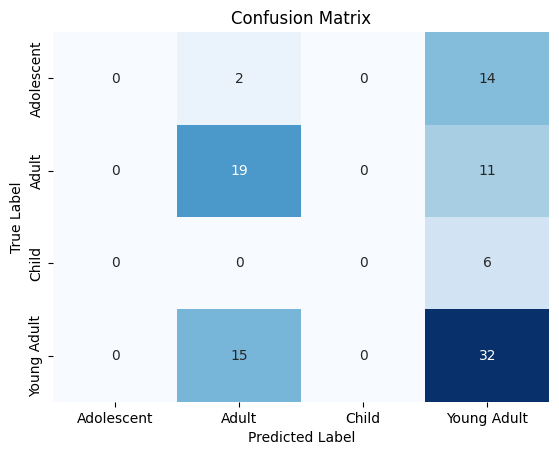

In [ ]:
trainingFile = "train_data.txt"
devFile = "dev_data.txt"
testFile = "test_data.txt"

run(trainingFile, devFile, testFile)

In [ ]:
trainingFile = "train_data.txt"
devFile = "dev_data.txt"
testFile = "test_data.txt"

run(trainingFile, devFile, testFile)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Test accuracy for best dev model: 0.475, 95% CIs: [0.376 0.573]

Class 'Adolescent' top features:
('ago',): 0.288
('said', '.'): 0.286
(',', 'though'): 0.271
('.', 'always'): 0.254
('fall',): 0.250
('ago', '.'): 0.249
('trust',): 0.243
('sound',): 0.234
('.', 'could'): 0.233
('early',): 0.230

Class 'Adult' top features:
('quality',): 0.277
('doctor',): 0.269
('terror',): 0.268
('love',): 0.264
('died',): 0.257
('present',): 0.247
('road',): 0.238
('able',): 0.236
(')',): 0.233
('sight',): 0.233

Class 'Child' top features:
('child',): 0.428
(':', '``'): 0.304
("''", 'said'): 0.291
('elephant',): 0.280
('jolly',): 0.274
('farmer',): 0.271
('surprise',): 0.250
('nice',): 0.242
('asked',): 0.241
('named',): 0.232

Class 'Young Adult' top features:
('london',): 0.290
('master',): 0.272
('young',): 0.268
('society',): 0.250
('store',): 0.235
('step',): 0.230
('mine', ','): 0.225
('government',): 0.225
('later',): 0.219
('general',): 0.216



NameError: name 'labels' is not defined

In [ ]:
import random

def load_data(file_path):
    """ Load data from a file. """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return data

def split_data(data, train_frac=0.6, dev_frac=0.2):
    """ Shuffle and split data into train, dev, and test sets. """
    random.shuffle(data)  # Shuffle the data randomly
    total = len(data)
    train_end = int(total * train_frac)
    dev_end = train_end + int(total * dev_frac)

    train_data = data[:train_end]
    dev_data = data[train_end:dev_end]
    test_data = data[dev_end:]
    return train_data, dev_data, test_data

def save_data(data, file_name):
    """ Save the data to a file. """
    with open(file_name, 'w', encoding='utf-8') as file:
        file.writelines(data)

# Example usage:
file_path = 'adjudicated.txt'  # Specify the path to your TXT file
data = load_data(file_path)
train_data, dev_data, test_data = split_data(data)

# Saving the datasets to different files
save_data(train_data, 'train_data.txt')
save_data(dev_data, 'dev_data.txt')
save_data(test_data, 'test_data.txt')